In [640]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [641]:
df = pd.read_json("logins.json")
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [642]:
df.shape

(93142, 1)

In [643]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


df.info()

In [644]:
df = (df.resample('15min', on='login_time').count()
                  .rename(columns={'login_time': 'login_count'})
                  .reset_index())
df.head(10)


,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
5,1970-01-01 21:15:00,4
6,1970-01-01 21:30:00,0
7,1970-01-01 21:45:00,4
8,1970-01-01 22:00:00,9
9,1970-01-01 22:15:00,8


#### Convert to Datetime

In [645]:
import datetime
df['login_time'] = pd.to_datetime(df['login_time'], format='%d%b%Y:%H:%M:%S.%f')



#### Login Count 

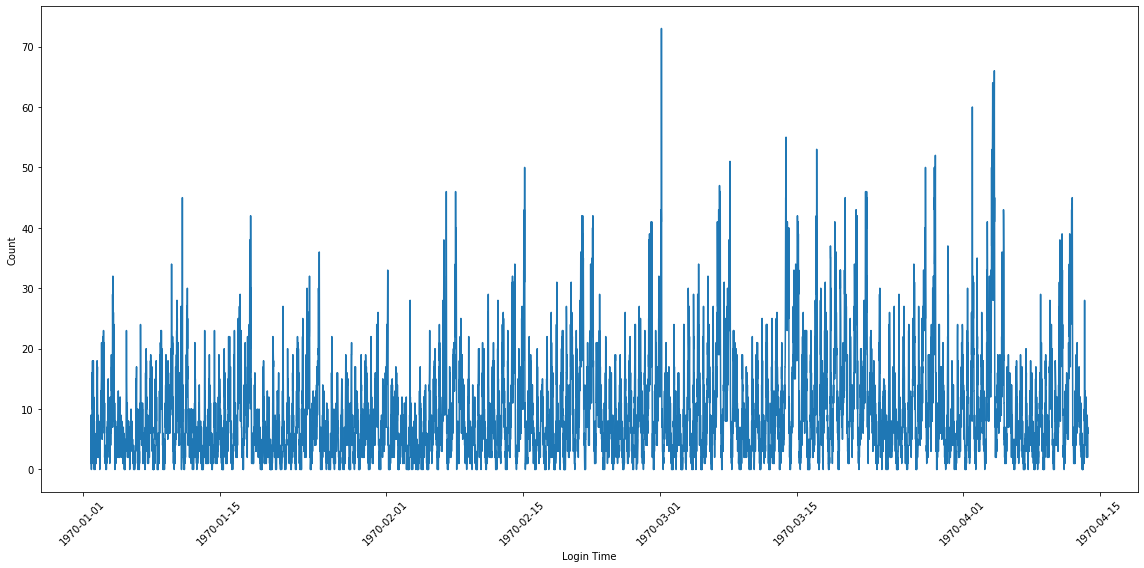

In [646]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='login_time',
             y='login_count',
             data=df)
plt.xticks(rotation=45)
plt.xlabel('Login Time')
plt.ylabel('Count')
plt.tight_layout()


#### Day of the Week

In [647]:
df['day_Of_Week'] = df['login_time'].dt.day_name().str[:3]
df['time_Of_Day'] = df['login_time'].dt.strftime('%H:%M')
df.login_time = pd.to_datetime(df.login_time).dt.date


In [648]:
df.head()

,login_time,login_count,day_Of_Week,time_Of_Day
0,1970-01-01,2,Thu,20:00
1,1970-01-01,6,Thu,20:15
2,1970-01-01,9,Thu,20:30
3,1970-01-01,7,Thu,20:45
4,1970-01-01,1,Thu,21:00


<ipython-input-649-1fc957dd540c>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


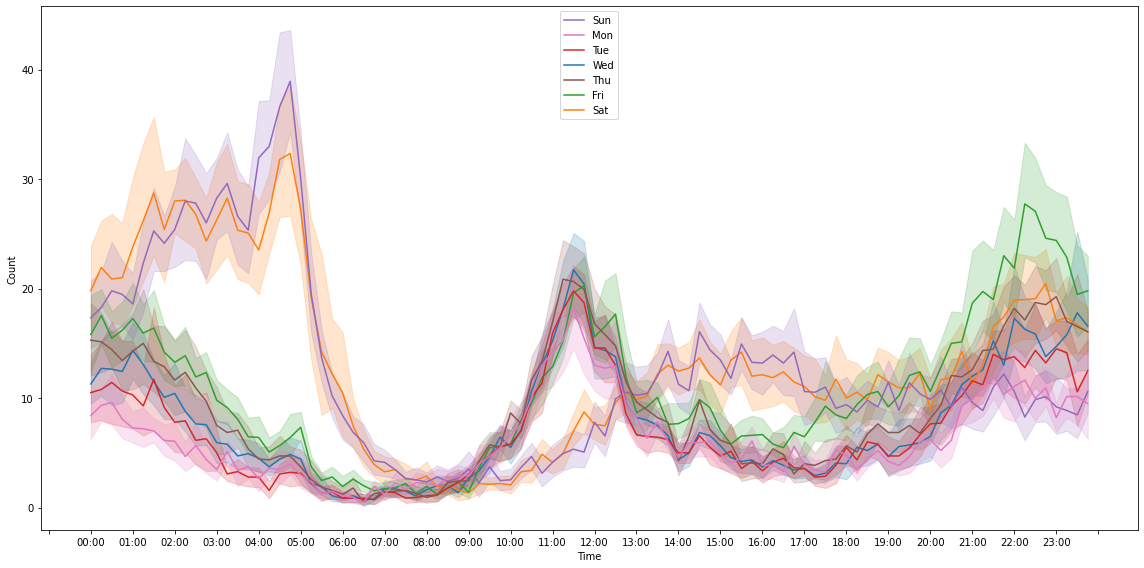

In [649]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(x='time_Of_Day',
             y='login_count',
             hue='day_Of_Week',
             data=df.sort_values(by='time_Of_Day'))
plt.xlabel('Time')
plt.ylabel('Count')

axs = plt.axes()
axs.xaxis.set_major_locator(ticker.MultipleLocator(4))

handles, labels = axs.get_legend_handles_labels()

handles = [handles[[i for i, day in list(enumerate(labels)) if day == 'Sun'][0]],
           handles[[i for i, day in list(
               enumerate(labels)) if day == 'Mon'][0]],
           handles[[i for i, day in list(
               enumerate(labels)) if day == 'Tue'][0]],
           handles[[i for i, day in list(
               enumerate(labels)) if day == 'Wed'][0]],
           handles[[i for i, day in list(
               enumerate(labels)) if day == 'Thu'][0]],
           handles[[i for i, day in list(
               enumerate(labels)) if day == 'Fri'][0]],
           handles[[i for i, day in list(enumerate(labels)) if day == 'Sat'][0]]]
labels = [labels[[i for i, day in list(enumerate(labels)) if day == 'Sun'][0]],
          labels[[i for i, day in list(enumerate(labels)) if day == 'Mon'][0]],
          labels[[i for i, day in list(enumerate(labels)) if day == 'Tue'][0]],
          labels[[i for i, day in list(enumerate(labels)) if day == 'Wed'][0]],
          labels[[i for i, day in list(enumerate(labels)) if day == 'Thu'][0]],
          labels[[i for i, day in list(enumerate(labels)) if day == 'Fri'][0]],
          labels[[i for i, day in list(enumerate(labels)) if day == 'Sat'][0]]]

axs.legend(handles, labels, loc='upper center')

plt.tight_layout()


# Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

    The metric of success I would use would be to take the average ratio of available drivers of each city. If the average is higher for city A or B then we can calculate whether the average ratio converges or stays the same after the initiative.

 
2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment
    I would implement the experiment by calculated the median of total number of available drivers before and after the initiative took place. If we see that the median converaged to an even split, .5 we can then assume that the initiative is working. 
    
b) what statistical test(s) you will conduct to verify the significance of the
observation

I would take the average ratio of avaliable driver per city. Since we don't know if each city has the  same number of drivers. Doing this will account for the sample ratio mismatch since we are assuming that there is a 50/50 split. Then I would multiply the observed number of drivers available by 5% that will become our expected value. Then using Chi statistics we would take the ((observed-expected)^2)/expected). After, calculate our degrees of freedom. Then, we can use a p value table to locate our score. Finally, if the p-value is below 5% we can conclude that we reject the null hypothesis meaning that there is a significant statistical difference in availablity of drivers in both cities. Else, we can accept the null hypothesis that there isn't a significant statistical difference in available drivers in both cities. We can simulate our findings using a bootstrap technique to estimate different permutations of our study. 

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveat

If we find that our p-value < 5% then we can assume that there is a statistical difference in availability of drivers for both cities. Therefore, we would recommend the city to continue reimbursing all toll costs. If we see that there isn't a significant difference in available drivers then we would encourage the city to try and find a different way to incentivize the drivers. 

Caveats:
Our study doesn't account for times of high demand, when there are not that many drivers on the roads for reasons such as weather, construction, and cost of gas. 

# Part 3

In [678]:
df = pd.read_json("ultimate_data_challenge.json")

In [679]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [652]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [680]:
isNull = pd.DataFrame(df.isnull().sum() * 100 / len(df))
isNull.columns = ['is_null_frac']
isNull

,is_null_frac
city,0.000
trips_in_first_30_days,0.000
signup_date,0.000
avg_rating_of_driver,16.244
avg_surge,0.000
last_trip_date,0.000
phone,0.792
surge_pct,0.000
ultimate_black_user,0.000
weekday_pct,0.000


It appears that about 16% of drivers don't have an average rating. That might be due to the lack of rides given. 

In [681]:
df.signup_date = pd.to_datetime(df.signup_date, infer_datetime_format=True)
df.last_trip_date = pd.to_datetime(df.last_trip_date, infer_datetime_format=True)

In [682]:
df.duplicated().sum()

8

In [683]:
df.drop_duplicates(keep='first')

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [684]:
df['retained'] = (df['last_trip_date'] >=
                  pd.to_datetime('2014-06-01')).astype('int')
df.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [686]:
retained_frac = round(df['retained'].mean()*100, 2)
print(f'{retained_frac} % of riders was retained.')


37.61 % of riders was retained.


# Categorical Columns

In [724]:
cat_df = df.select_dtypes('object').columns.tolist()
cols = cat_df + bool_df

In [688]:
andvsiph = df.groupby('phone')['retained'].value_counts()
andvsiph

phone    retained
Android  0           11876
         1            3146
iPhone   0           19057
         1           15525
Name: retained, dtype: int64

Interesting observation, more than double the amount of iPhone users use the rider system. 

In [689]:
df['city'].value_counts(0).head()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

Seems like Winterfell resident have the most amount of users.

In [690]:
thritydays = df.groupby('city')['retained'].value_counts()
thritydays

city            retained
Astapor         0           12306
                1            4228
King's Landing  1            6363
                0            3767
Winterfell      0           15123
                1            8213
Name: retained, dtype: int64

Winterfell also leads with the number of retention. It might be that Winterfell is a large city. 

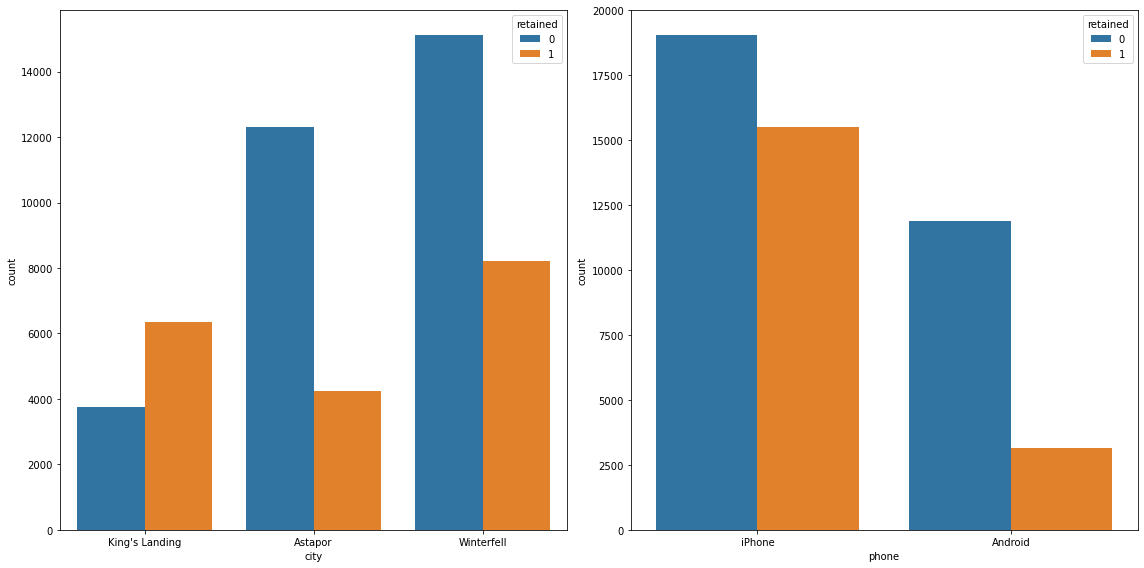

In [691]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for cat_df, ax in zip(cat_df, axes.flatten()):
    sns.countplot(data=df,
                  x=cat_df,
                  hue='retained',
                  ax=ax)

fig.tight_layout()


In [692]:
thritydays.head()

city            retained
Astapor         0           12306
                1            4228
King's Landing  1            6363
                0            3767
Winterfell      0           15123
Name: retained, dtype: int64

# Numerical Columns

In [693]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime64[ns]', 'bool']).columns.tolist()
numeric_df

['trips_in_first_30_days',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 'retained']

In [666]:
df[numeric_df].describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
retained,50000.0,0.376080,0.484405,0.0,0.00,0.00,1.00,1.00


In [694]:
df[numeric_df].quantile(.95)


trips_in_first_30_days      9.00
avg_rating_of_driver        5.00
avg_surge                   1.38
surge_pct                  50.00
weekday_pct               100.00
avg_dist                   16.78
avg_rating_by_driver        5.00
retained                    1.00
Name: 0.95, dtype: float64

There are some questionable numbers but we need to consider that some users might now have a car and they rely on the drivers. 

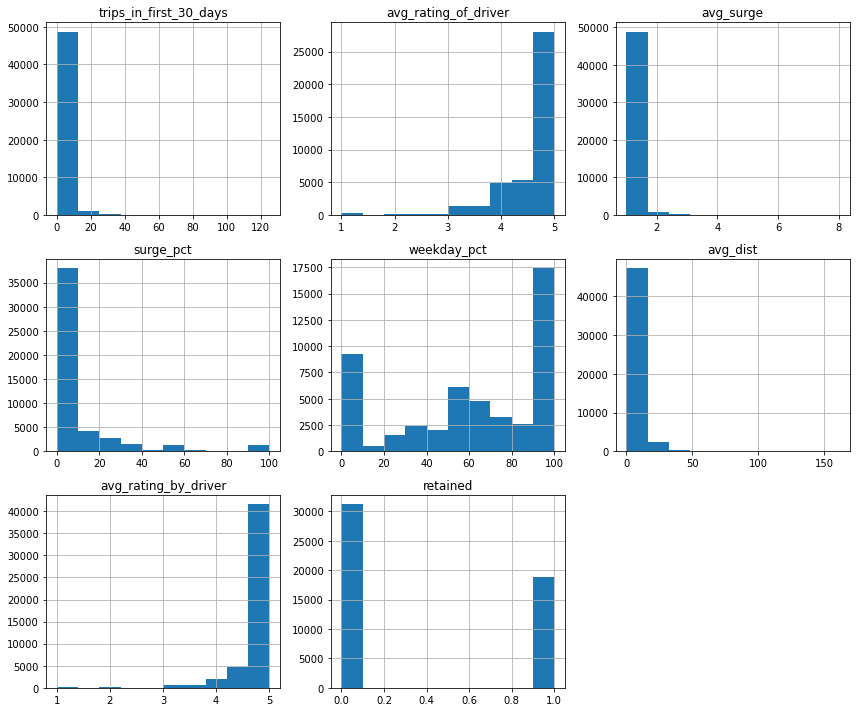

In [695]:
df[numeric_df].hist(bins=10, figsize=(12, 10))
plt.tight_layout()


We can see that 'avg_rating_of_driver' and 'avg_rating_by_driver' are correlated. Same with 'surge_pct', and 'avg_surge'. We can explore these relationships using a heatmap.

<AxesSubplot:xlabel='city', ylabel='surge_pct'>

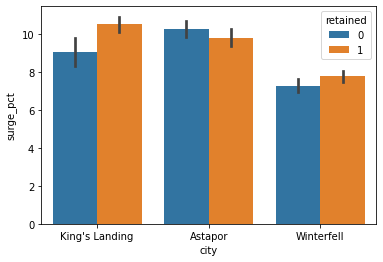

In [696]:
sns.barplot(data=df, x='city', y='surge_pct', hue='retained')

<AxesSubplot:xlabel='city', ylabel='avg_surge'>

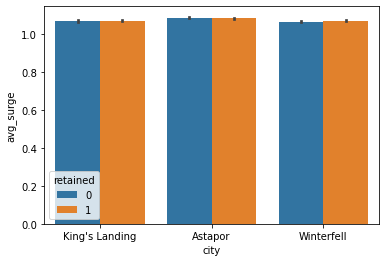

In [670]:
sns.barplot(data=df, x='city', y='avg_surge', hue='retained')

There doesn't seem to be any relationship between the average surge and retention rate. We would assume that more drivers would be retained if they were paid a bit extra during high demand times.

# Boolean Column

In [725]:
bool_df = df.select_dtypes('bool').columns.tolist()
bool_df

['ultimate_black_user']

<AxesSubplot:xlabel='ultimate_black_user', ylabel='count'>

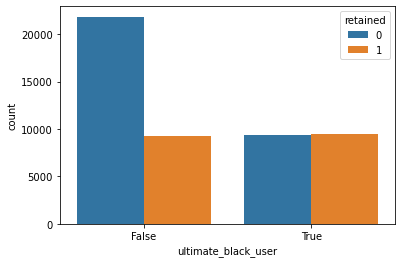

In [698]:
sns.countplot(x='ultimate_black_user', hue='retained', data=df)

# Summary 

Key Findings and Insight
- Approximetely 38% of riders were retained
- King's Landing has the highest retention rate at ~63% and Astapor the lowest at ~26%. Winterfell had to highest number of retained riders at 8.2K
- iPhone user has a retention rate of ~45% vs Android at ~21%
- Surge occurances don't seem to affect riders
- Being an ultimate black user doesn't seem correlate with retention rate

# Feature Engineering & Modeling

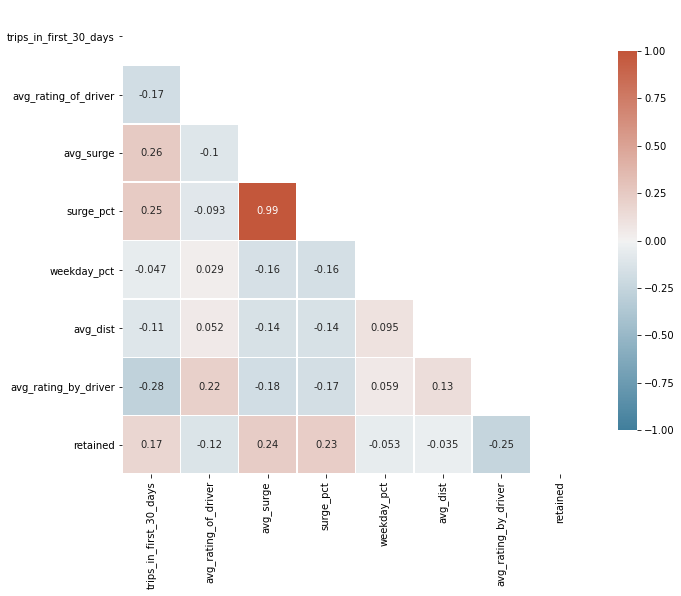

In [699]:
corr_matrix = df[numeric_df].corr('spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot=True)
plt.tight_layout()


Just as I had mention earlier surge_pct and avg_surge are almost 100% correlated. We should drop one of the them to prevent nulticollinearity. 

In [700]:
df['signup_day'] = df['signup_date'].dt.dayofweek
df['signup_day_is_weekend'] = np.where((df['signup_day'] == 5)
                                       | (df['signup_day'] == 6), 1, 0)

df[['signup_day', 'signup_day_is_weekend']]


,signup_day,signup_day_is_weekend
0,5,1
1,2,0
2,0,0
3,4,0
4,0,0
...,...,...
49995,5,1
49996,4,0
49997,4,0
49998,1,0


In [701]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime64[ns]', 'bool']).columns.tolist()
numeric_df.remove('retained')
numeric_df

['trips_in_first_30_days',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 'signup_day',
 'signup_day_is_weekend']

In [702]:
df.head(2)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_day,signup_day_is_weekend
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,5,1
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,2,0


In [744]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')


In [711]:
X = df.drop('retained', axis=1)
y = df[['retained']]



X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(37500, 14)
(12500, 14)
(37500, 1)
(12500, 1)


In [712]:
y_train.mean(), y_test.mean()


(retained    0.37488
 dtype: float64,
 retained    0.37968
 dtype: float64)

In [713]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')


In [718]:
cat_df

'phone'

In [726]:
# Preprocessing for numerical data and fill missing values
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_df),
        ('cat', categorical_transformer, cols)
    ])


# XGBoost Model

In [727]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf =xgb.XGBClassifier()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_clf)])

In [728]:
from sklearn.model_selection import RandomizedSearchCV

# Parameters for Randomized search
parameters = {'preprocessor__num__strategy': ['mean', 'median'],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
              'classifier__learning_rate': [0.1, 0.3, 0.5],
              'classifier__max_depth': range(1, 12, 1),
              'classifier__subsample': [0.8, 1],
              'classifier__min_child_weight': [0.5, 1, 3],
              'classifier__n_estimators': [50, 100, 300, 500],
              'classifier__scale_pos_weight': [1, 1.7, 2]}

# Randomized search
search_xgb = RandomizedSearchCV(estimator=pipe_xgb,
                                param_distributions=parameters,
                                n_iter=60,
                                cv=2,
                                scoring='f1',
                                return_train_score=True,
                                random_state=42,
                                verbose=1)

# Preprocessing of training data, fit model
search_xgb.fit(X_train, y_train)


Fitting 2 folds for each of 60 candidates, totalling 120 fits


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:37:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:38:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:41:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\luisr\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['trips_in_first_30_days',
                                                                                'avg_rating_of_driver',
                                                                                'avg_surge',
                                                                                'surge_pct',
                                                                                'weekday_pct',
                                                                                'avg_dist',
                                                                                'avg_rating_by_driver',
                                                                                'signup_day',
                                                                                'signup_day_is_weekend']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(stra...
                                        'classifier__max_depth': range(1, 12),
                                        'classifier__min_child_weight': [0.5, 1,
                                                                         3],
                                        'classifier__n_estimators': [50, 100,
                                                                     300, 500],
                                        'classifier__scale_pos_weight': [1, 1.7,
                                                                         2],
                                        'classifier__subsample': [0.8, 1],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__num__strategy': ['mean',
                                                                        'median']},
                   random_state=42, return_train_score=True, scoring='f1',
                   verbose=1)

In [730]:
opt_xgb_clf = search_xgb.best_estimator_
search_xgb.best_params_

{'preprocessor__num__strategy': 'median',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'classifier__subsample': 1,
 'classifier__scale_pos_weight': 1.7,
 'classifier__n_estimators': 300,
 'classifier__min_child_weight': 1,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.1}

In [731]:
y_pred_train_xgb = opt_xgb_clf.predict(X_train)
y_pred_test_xgb = opt_xgb_clf.predict(X_test)
y_pred_proba_train_xgb = opt_xgb_clf.predict_proba(X_train)
y_pred_proba_test_xgb = opt_xgb_clf.predict_proba(X_test)


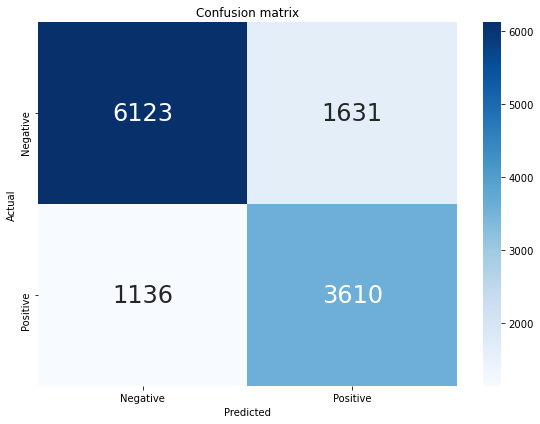

In [732]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_test_xgb)
lables = {0: 'Negative', 1: 'Positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            annot_kws={'size': 24},
            fmt="d",
            xticklabels=lables.values(),
            yticklabels=lables.values(),
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()


In [734]:

print(classification_report(y_test, y_pred_test_xgb))


              precision    recall  f1-score   support

           0       0.84      0.79      0.82      7754
           1       0.69      0.76      0.72      4746

    accuracy                           0.78     12500
   macro avg       0.77      0.78      0.77     12500
weighted avg       0.78      0.78      0.78     12500



In [738]:


precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(
    y_test, y_pred_proba_test_xgb[:, 1])
pr_auc_test_xgb = auc(recall_xgb, precision_xgb)
fscore_xgb = (2 * precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
opt_fscore_xgb_index = np.argmax(fscore_xgb)
threshold_xgb_opt = round(thresholds_xgb[opt_fscore_xgb_index], 2)
fscore_xgb_opt = round(fscore_xgb[opt_fscore_xgb_index], 2)
recall_xgb_opt = round(recall_xgb[opt_fscore_xgb_index], 2)
precision_xgb_opt = round(precision_xgb[opt_fscore_xgb_index], 2)


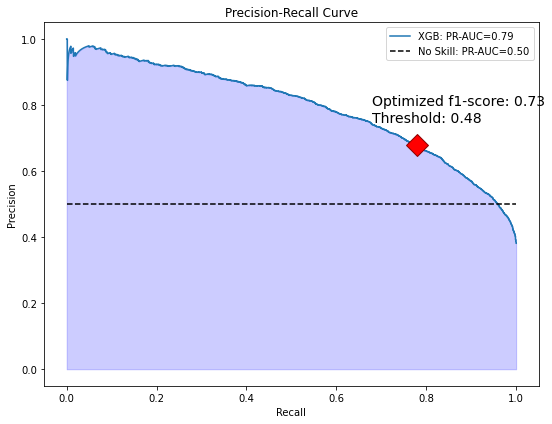

In [739]:
plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb,
         label='XGB: PR-AUC={:.2f}'.format(pr_auc_test_xgb))
plt.plot([0, 1], [0.5, .5], '--', color='black', label='No Skill: PR-AUC=0.50')
plt.plot(recall_xgb_opt, precision_xgb_opt, marker='D',
         markersize=16, color='r', markeredgecolor='darkred')
plt.annotate('Optimized f1-score: {:.2f}\nThreshold: {:.2f}\n '
             .format(fscore_xgb_opt, round(threshold_xgb_opt, 2)),
             xy=(.68, .7), fontsize=14)
plt.fill_between(recall_xgb, precision_xgb, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.title('Precision-Recall Curve')
plt.tight_layout()


In [740]:
roc_auc_train_xgb = round(roc_auc_score(
    y_train, y_pred_proba_train_xgb[:, 1]), 2)
roc_auc_test_xgb = round(roc_auc_score(y_test, y_pred_proba_test_xgb[:, 1]), 2)
print('Train Set ROC AUC:', roc_auc_train_xgb)
print('Test Set ROC AUC:', roc_auc_test_xgb)


Train Set ROC AUC: 0.88
Test Set ROC AUC: 0.86


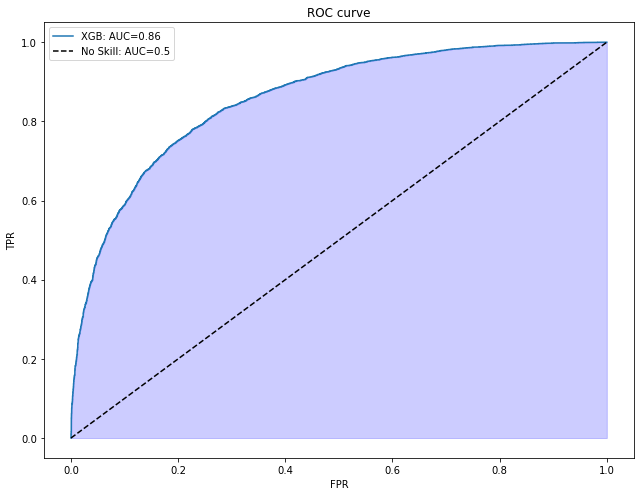

In [741]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    y_test, y_pred_proba_test_xgb[:, 1])

plt.figure(figsize=(9, 7))
plt.plot(fpr_xgb, tpr_xgb, label='XGB: AUC={}'.format(roc_auc_test_xgb))
plt.fill_between(fpr_xgb, tpr_xgb, alpha=0.2, color='b')
plt.plot([0, 1], [0, 1], '--', color='black', label='No Skill: AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=2)
plt.title('ROC curve')
plt.tight_layout()


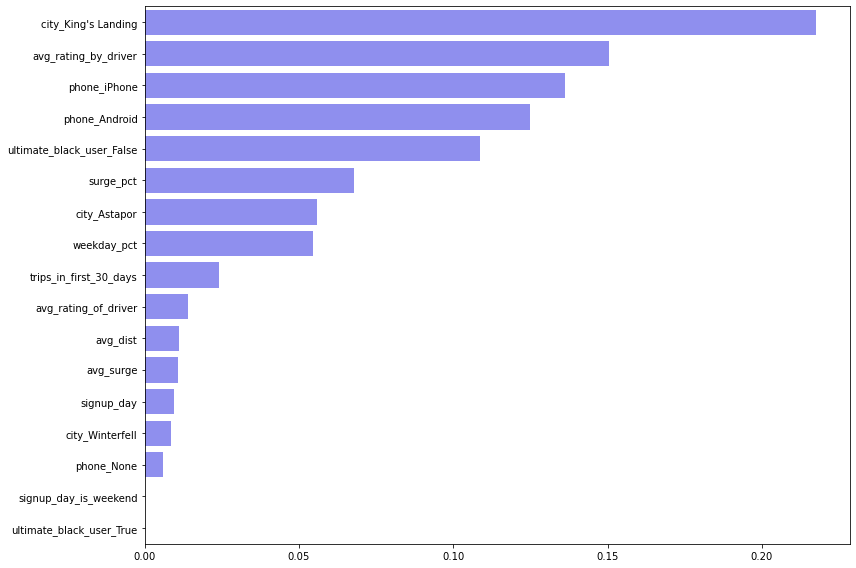

In [742]:
# Preprocess data with best parameters
numerical_transformer_rev = SimpleImputer(strategy=search_xgb.best_params_[
                                          'preprocessor__num__strategy'])
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search_xgb.best_params_[
     'preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, numeric_df),
        ('cat', categorical_transformer_rev, cols)
    ])

pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev)])
X_values = preprocessor_rev.fit_transform(X_train, y_train)
onehot_col = pipeline_rev.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names(input_features=cols)
columns_tot = numeric_df + onehot_col.tolist()

feature_importance = pd.Series(data=opt_xgb_clf.named_steps['classifier'].feature_importances_,
                               index=np.array(columns_tot)).sort_values(ascending=False)

# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(y=feature_importance.index[:20],
            x=feature_importance.values[:20],
            color='blue',
            alpha=.5,
            orient='h')
plt.tight_layout()


# LightGBM Model

In [743]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Define model
lgbm_clf = LGBMClassifier(objective='binary',
                          random_state=42)

# Make pipeline with preprocessing and model
pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', lgbm_clf)
                                ])

# Randomized search
parameters = {'preprocessor__num__strategy': ['mean', 'median'],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
              'classifier__learning_rate': [0.1, 0.3, 0.5],
              'classifier__max_depth': [-1, 1, 2, 3, 4, 5, 8, 10],
              'classifier__bagging_fraction': [0.7, 1.0],
              'classifier__num_leaves': range(20, 60, 10),
              'classifier__n_estimators': [100, 200, 300]}

search_lgbm = RandomizedSearchCV(estimator=pipeline_lgbm,
                                 param_distributions=parameters,
                                 n_iter=60,
                                 cv=5,
                                 scoring='f1',
                                 return_train_score=True,
                                 verbose=3)

# Preprocessing of training data, fit model
search_lgbm.fit(X_train, y_train)


C:\Users\luisr\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\luisr\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\luisr\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.3s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.9s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.9s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.4s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.1s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.3s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.3s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.3s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.3s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.5s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.5s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.5s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.4s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.0s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.4s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   2.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   2.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   2.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   2.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.9s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.3s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.3s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.2s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.3s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   2.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   2.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=2, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.7s
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   2.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.6s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.8s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   1.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   2.1s
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=-1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=mean; total time=   2.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=10, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.3, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=4, classifier__n_estimators=200, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.7s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=1, classifier__n_estimators=300, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   2.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.1s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   2.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   2.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=8, classifier__n_estimators=200, classifier__num_leaves=40, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=20, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   2.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=50, preprocessor__cat__imputer__strategy=constant, preprocessor__num__strategy=median; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.6s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=2, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.5s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=median; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.8s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.3s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 4/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.4s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 5/5] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 2/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.0s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 4/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   1.2s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 5/5] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=30, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__strategy=mean; total time=   0.9s


C:\Users\luisr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['trips_in_first_30_days',
                                                                                'avg_rating_of_driver',
                                                                                'avg_surge',
                                                                                'surge_pct',
                                                                                'weekday_pct',
                                                                                'avg_dist',
                                                                                'avg_rating_by_driver',
                                                                                'signup_day',
                                                                                'signup_day_is_weekend']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(stra...
                   param_distributions={'classifier__bagging_fraction': [0.7,
                                                                         1.0],
                                        'classifier__learning_rate': [0.1, 0.3,
                                                                      0.5],
                                        'classifier__max_depth': [-1, 1, 2, 3,
                                                                  4, 5, 8, 10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__num_leaves': range(20, 60, 10),
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__num__strategy': ['mean',
                                                                        'median']},
                   return_train_score=True, scoring='f1', verbose=3)

In [745]:
opt_lgbm_clf = search_lgbm.best_estimator_
search_lgbm.best_params_


{'preprocessor__num__strategy': 'median',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'classifier__num_leaves': 40,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.1,
 'classifier__bagging_fraction': 1.0}

In [746]:
y_pred_train_lgbm = opt_lgbm_clf.predict(X_train)
y_pred_test_lgbm = opt_lgbm_clf.predict(X_test)
y_pred_proba_train_lgbm = opt_lgbm_clf.predict_proba(X_train)
y_pred_proba_test_lgbm = opt_lgbm_clf.predict_proba(X_test)


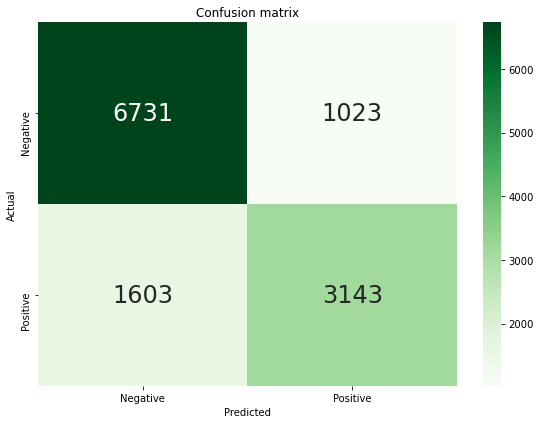

In [747]:
conf_matrix = confusion_matrix(y_test, y_pred_test_lgbm)
lables = {0: 'Negative', 1: 'Positive'}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            annot_kws={'size': 24},
            fmt="d",
            xticklabels=lables.values(),
            yticklabels=lables.values(),
            cmap="Greens")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()


In [748]:
print(classification_report(y_test, y_pred_test_lgbm))


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      7754
           1       0.75      0.66      0.71      4746

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500



In [749]:
precision_lgbm, recall_lgbm, thresholds_lgbm = precision_recall_curve(
    y_test, y_pred_proba_test_lgbm[:, 1])
pr_auc_test_lgbm = auc(recall_lgbm, precision_lgbm)
fscore_lgbm = (2 * precision_lgbm * recall_lgbm) / \
    (precision_lgbm + recall_lgbm)
opt_fscore_lgbm_index = np.argmax(fscore_lgbm)
threshold_lgbm_opt = round(thresholds_lgbm[opt_fscore_lgbm_index], 2)
fscore_lgbm_opt = round(fscore_lgbm[opt_fscore_lgbm_index], 2)
recall_lgbm_opt = round(recall_lgbm[opt_fscore_lgbm_index], 2)
precision_lgbm_opt = round(precision_lgbm[opt_fscore_lgbm_index], 2)


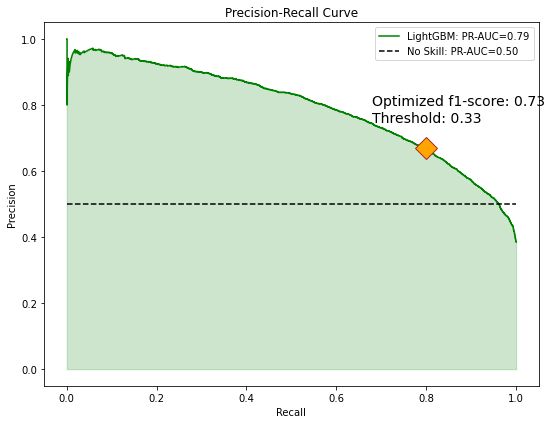

In [750]:
plt.figure(figsize=(8, 6))
plt.plot(recall_lgbm, precision_lgbm,
         label='LightGBM: PR-AUC={:.2f}'.format(pr_auc_test_lgbm), color='g')
plt.plot([0, 1], [0.5, .5], '--', color='black', label='No Skill: PR-AUC=0.50')
plt.plot(recall_lgbm_opt, precision_lgbm_opt, marker='D',
         markersize=16, color='orange', markeredgecolor='brown')
plt.annotate('Optimized f1-score: {:.2f}\nThreshold: {:.2f}\n '
             .format(fscore_lgbm_opt, round(threshold_lgbm_opt, 2)),
             xy=(.68, .7), fontsize=14)
plt.fill_between(recall_lgbm, precision_lgbm, alpha=0.2, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.title('Precision-Recall Curve')
plt.tight_layout()


In [751]:
roc_auc_train_lgbm = round(roc_auc_score(
    y_train, y_pred_proba_train_lgbm[:, 1]), 2)
roc_auc_test_lgbm = round(roc_auc_score(
    y_test, y_pred_proba_test_lgbm[:, 1]), 2)
print('Train Set ROC AUC:', roc_auc_train_lgbm)
print('Test Set ROC AUC:', roc_auc_test_lgbm)


Train Set ROC AUC: 0.88
Test Set ROC AUC: 0.86


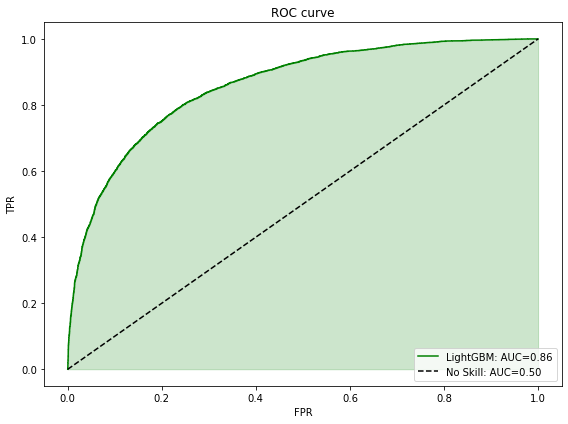

In [752]:
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(
    y_test, y_pred_proba_test_lgbm[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='g',
         label='LightGBM: AUC={}'.format(roc_auc_test_lgbm))
plt.fill_between(fpr_lgbm, tpr_lgbm, alpha=0.2, color='g')
plt.plot([0, 1], [0, 1], '--', color='black', label='No Skill: AUC=0.50')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.title('ROC curve')
plt.tight_layout()


# LightGBM Feature Importance

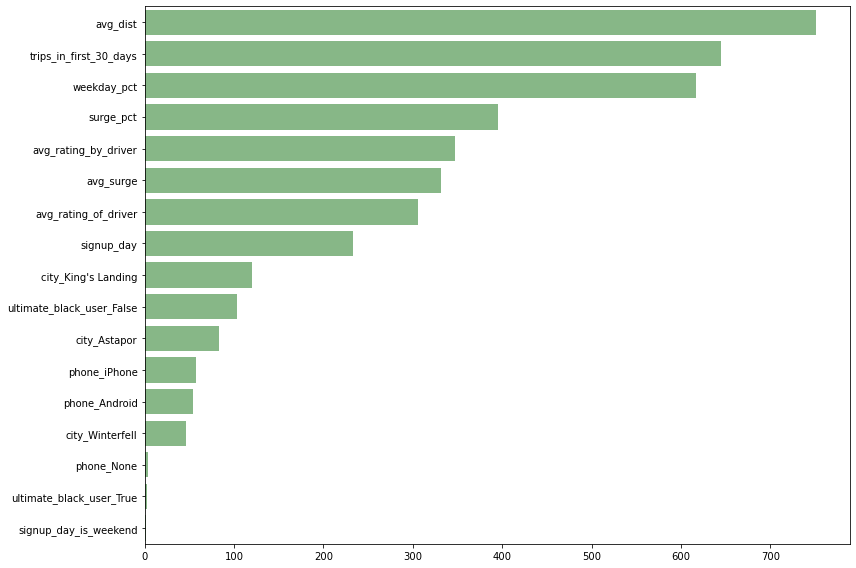

In [753]:
# Preprocess data with best parameters
numerical_transformer_rev = SimpleImputer(strategy=search_lgbm.best_params_[
                                          'preprocessor__num__strategy'])
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search_lgbm.best_params_[
     'preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, numeric_df),
        ('cat', categorical_transformer_rev, cols)
    ])

pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev)])
X_values = preprocessor_rev.fit_transform(X_train, y_train)
onehot_col = pipeline_rev.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names(input_features=cols)
columns_tot = numeric_df + onehot_col.tolist()

feature_importance = pd.Series(data=opt_lgbm_clf.named_steps['classifier'].feature_importances_,
                               index=np.array(columns_tot)).sort_values(ascending=False)

# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(y=feature_importance.index[:20],
            x=feature_importance.values[:20],
            color='green',
            alpha=.5,
            orient='h')
plt.tight_layout()


# Model Comparison

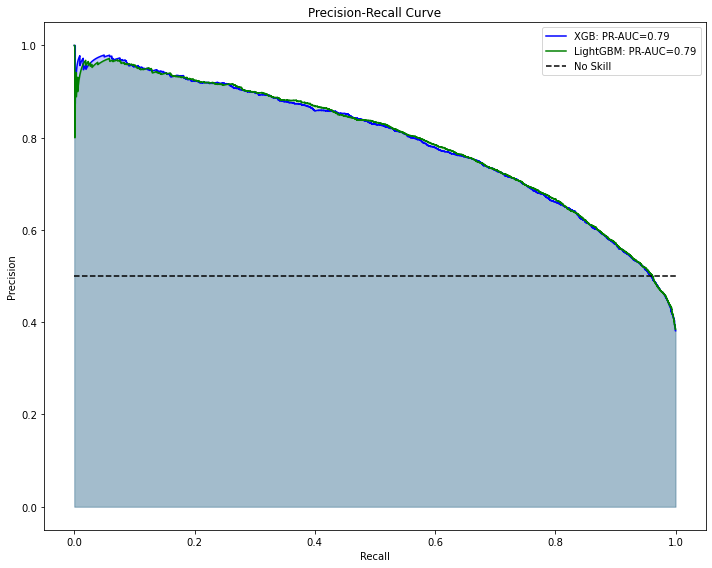

In [754]:
plt.figure(figsize=(10, 8))
plt.plot(recall_xgb, precision_xgb,
         label='XGB: PR-AUC={:.2f}'.format(pr_auc_test_xgb), color='b')
plt.plot(recall_lgbm, precision_lgbm,
         label='LightGBM: PR-AUC={:.2f}'.format(pr_auc_test_lgbm), color='g')
plt.plot([0, 1], [0.5, .5], '--', color='black', label='No Skill')
plt.fill_between(recall_xgb, precision_xgb, alpha=0.2, color='b')
plt.fill_between(recall_lgbm, precision_lgbm, alpha=0.2, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.title('Precision-Recall Curve')
plt.tight_layout()


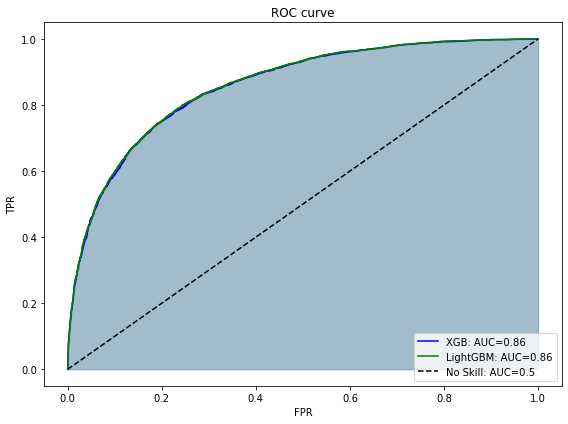

In [755]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='b',
         label='XGB: AUC={}'.format(roc_auc_test_xgb))
plt.plot(fpr_lgbm, tpr_lgbm, color='g',
         label='LightGBM: AUC={}'.format(roc_auc_test_lgbm))
plt.fill_between(fpr_xgb, tpr_xgb, alpha=0.2, color='b')
plt.fill_between(fpr_lgbm, tpr_lgbm, alpha=0.2, color='g')
plt.plot([0, 1], [0, 1], '--', color='black', label='No Skill: AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.title('ROC curve')
plt.tight_layout()


# Conclusions



The XGBoost and LightGBM models offer similar performance. Looking at precision and recall metrics, which are particularly interesting in view of the business problem, we see that both models provide decent performance. In fact, the LightGMB model has recall of 87% (79% for XGB) on the inactive users and 67% (77% for XGB) of retained (active). This implies a f1-score of about 87% for the inactive riders in the LightGBM model (79% for the XGB model) and 70% for the retained riders (72% for the XGB model).

The difference in performance is mainly due to the class imbalance of the dataset. However, the LightGBM model turns out to be very useful in predicting potential inactive users (high recall), hence Ultimate Technologies could use this tool to identify customers which are likely to be inactive in the near future and come up with strategies to incentivize this group to remain active by improving their experience. Furthermore, the company could focus on the most predictive features and run design experiments to improve increase the overall retention rate, e.g. by performing A/B testing and hypothesis testing.

The results are satisfying, especially given the modest amount of data considered. Further improvement could be achieved by increasing the data. A stratified solution, e.g. developing different models for user from different cities or using different phones could be tested to see if we gain better performance. Another option to boost the performance is to use a stacked model, but with the downside of reducing interpretability.

       
